#### **1. Importing Libraries**

In [1]:
import pandas as pd                                                 # Importing for panel data analysis
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface of matplotlib
import seaborn as sns                                               # Importing seaborn library for interactive visualization
%matplotlib inline
import random
import math
import time
import os
#--------------------~-----------------------------------------------------------------------------------------------------------
import pyfpgrowth                                                   # For testing the scratch implementation
#-------------------------------------------------------------------------------------------------------------------------------
import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")                                   # Warnings will appear only once

In [2]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
print('Shape of the dataset:', ratings.shape)
ratings.head(5)

Shape of the dataset: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [4]:
print("Number of unique users:", ratings["userId"].nunique())

Number of unique users: 610


In [5]:
print("Number of unique movies:", ratings["movieId"].nunique())

Number of unique movies: 9724


#### **2. Data preprocessing**

- Form the transactional data set, which consists of entries of the form <user id, {movies rated above 2}
- Consider only those users who have rated more than 10 movies
- Divide the data set into 80% training set and 20% test set. Remove 20% of movies watched from each user and create a test set using the removed movies

In [6]:
# let's extract the number of unique movies and its corresponding ratings
group = ratings.groupby('movieId')
df = group.apply(lambda x: x['rating'].unique())
df

movieId
1             [4.0, 4.5, 2.5, 3.5, 3.0, 5.0, 0.5, 2.0, 1.5]
2         [4.0, 3.0, 3.5, 4.5, 2.5, 5.0, 1.5, 1.0, 2.0, ...
3             [4.0, 5.0, 3.0, 3.5, 2.0, 1.0, 2.5, 0.5, 1.5]
4                                      [3.0, 1.0, 2.0, 1.5]
5             [5.0, 3.0, 4.0, 2.0, 3.5, 4.5, 1.5, 2.5, 0.5]
                                ...                        
193581                                                [4.0]
193583                                                [3.5]
193585                                                [3.5]
193587                                                [3.5]
193609                                                [4.0]
Length: 9724, dtype: object

- So, there are movies that have been rated 2 or less. Let's keep only entries where movie ratings are greater than 2. 

In [7]:
ratings_above_2 = ratings[ratings["rating"] > 2.0]
ratings_above_2

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
# Let's extract the number of unique movies that each user might have rated
group = ratings_above_2.groupby('userId')
df = group.apply(lambda x: len(x['movieId'].unique()))
df

userId
1       226
2        28
3        18
4       167
5        40
       ... 
606    1070
607     174
608     670
609      37
610    1233
Length: 610, dtype: int64

In [9]:
count_freq = dict(df)
count_freq

{1: 226,
 2: 28,
 3: 18,
 4: 167,
 5: 40,
 6: 294,
 7: 111,
 8: 43,
 9: 34,
 10: 119,
 11: 59,
 12: 32,
 13: 28,
 14: 42,
 15: 111,
 16: 96,
 17: 105,
 18: 493,
 19: 357,
 20: 210,
 21: 380,
 22: 70,
 23: 120,
 24: 107,
 25: 26,
 26: 19,
 27: 109,
 28: 476,
 29: 78,
 30: 34,
 31: 45,
 32: 99,
 33: 137,
 34: 67,
 35: 22,
 36: 35,
 37: 20,
 38: 63,
 39: 90,
 40: 94,
 41: 170,
 42: 353,
 43: 114,
 44: 38,
 45: 366,
 46: 42,
 47: 111,
 48: 33,
 49: 21,
 50: 236,
 51: 319,
 52: 130,
 53: 20,
 54: 31,
 55: 16,
 56: 46,
 57: 379,
 58: 103,
 59: 101,
 60: 22,
 61: 37,
 62: 357,
 63: 248,
 64: 504,
 65: 34,
 66: 337,
 67: 33,
 68: 1085,
 69: 44,
 70: 61,
 71: 30,
 72: 45,
 73: 187,
 74: 177,
 75: 51,
 76: 87,
 77: 25,
 78: 47,
 79: 60,
 80: 167,
 81: 17,
 82: 207,
 83: 95,
 84: 287,
 85: 27,
 86: 69,
 87: 20,
 88: 52,
 89: 425,
 90: 53,
 91: 495,
 92: 24,
 93: 97,
 94: 44,
 95: 160,
 96: 66,
 97: 35,
 98: 81,
 99: 44,
 100: 141,
 101: 50,
 102: 52,
 103: 362,
 104: 254,
 105: 717,
 106: 33,
 10

In [10]:
# create a new column to record the number of movies rated by each userId
ratings_above_2['count_freq_userId'] = ratings_above_2['userId']
ratings_above_2['count_freq_userId'] = ratings_above_2['count_freq_userId'].map(count_freq)
ratings_above_2

,userId,movieId,rating,timestamp,count_freq_userId
0,1,1,4.0,964982703,226
1,1,3,4.0,964981247,226
2,1,6,4.0,964982224,226
3,1,47,5.0,964983815,226
4,1,50,5.0,964982931,226
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,1233
100832,610,168248,5.0,1493850091,1233
100833,610,168250,5.0,1494273047,1233
100834,610,168252,5.0,1493846352,1233


----

- Let's keep only those users who have rated more than 10 movies.

In [11]:
# Now let's remove the rows where the value of 'count_freq_userId' is less than 10.
more_than_10_movies_rated_above_2 = ratings_above_2.drop(ratings_above_2[ratings_above_2['count_freq_userId'] <= 10].index)
print(more_than_10_movies_rated_above_2)

        userId  movieId  rating   timestamp  count_freq_userId
0            1        1     4.0   964982703                226
1            1        3     4.0   964981247                226
2            1        6     4.0   964982224                226
3            1       47     5.0   964983815                226
4            1       50     5.0   964982931                226
...        ...      ...     ...         ...                ...
100831     610   166534     4.0  1493848402               1233
100832     610   168248     5.0  1493850091               1233
100833     610   168250     5.0  1494273047               1233
100834     610   168252     5.0  1493846352               1233
100835     610   170875     3.0  1493846415               1233

[87295 rows x 5 columns]


In [12]:
print("Number of unique users:", more_than_10_movies_rated_above_2["userId"].nunique())

Number of unique users: 607


In [13]:
print("Number of unique movies:", more_than_10_movies_rated_above_2["movieId"].nunique())

Number of unique movies: 8852


- As we observe, the number of unique users are reduced from 610 to 607 after preprocessing, <br />and the number of unique movies have reduced from 9724 to 8852.

----

- Let's create the transactional data of the form <user id, {movies rated above 2}>

In [14]:
# make a new dataframe with all unique userId
transactional_df = pd.DataFrame({'userId':more_than_10_movies_rated_above_2.userId.unique()})

# And then just get the list of all unique subreddits they are active in, assigning it to a new column
transactional_df['movies_rated_above_2'] = [set(more_than_10_movies_rated_above_2['movieId'].loc[more_than_10_movies_rated_above_2['userId'] == x['userId']]) 
    for _, x in transactional_df.iterrows()]

transactional_df

,userId,movies_rated_above_2
0,1,"{1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ..."
1,2,"{115713, 122882, 48516, 91529, 80906, 91658, 1..."
2,3,"{70946, 2851, 5764, 4518, 26409, 7991, 1275, 2..."
3,4,"{1025, 3079, 3083, 21, 1046, 2583, 4121, 538, ..."
4,5,"{1, 515, 261, 265, 527, 531, 21, 150, 534, 153..."
...,...,...
602,606,"{1, 8195, 6148, 7, 11, 69644, 4109, 15, 17, 18..."
603,607,"{1, 517, 2053, 2054, 1544, 3081, 11, 1036, 257..."
604,608,"{1, 4105, 10, 6157, 16, 21, 31, 32, 2080, 34, ..."
605,609,"{1, 137, 10, 650, 1161, 786, 150, 288, 161, 10..."


----

- Divide the data set (transactional_df) into 80% training set and 20% test set. Remove 20% of
movies watched from each user and create a test set using the removed
movies

In [15]:
# dividing transactional_df df into 80-20 train-test, such that 20% of movies watched from each user is test set.
'''
- Parse through each user
- Randomly shuffle the items in the list and split into 80-20
- extract 20 of each user and make a separate df
'''

cols = ['userId', 'movies_rated_above_2']
train_df = pd.DataFrame(columns=cols)
test_df = pd.DataFrame(columns=cols)

# loop through the rows using iterrows()
random.seed(0)
for index, row in transactional_df.iterrows():
    # print(row['userId'], row['movies_rated_above_2'])
    # print(row['movies_rated_above_2'])
    # print("-----")
    n = int(np.ceil(0.2 * len(row['movies_rated_above_2']))) # initialize a value that represents 20% of the total items in the list.
    test_list = random.sample(list(row['movies_rated_above_2']), n)  # randomly choose 20% of the values (n) from list and make a sublist.
    # print("test_list", test_list)
    # print("-----")
    train_list = [i for i in row['movies_rated_above_2'] if i not in test_list] # rest 80% values of list is in train_list
    # print("train_list", train_list)
    # print("******************************************************")
    
    df_1 = pd.DataFrame({
    'userId': [row['userId']],
    'movies_rated_above_2': [train_list]
    })

    df_2 = pd.DataFrame({
    'userId': [row['userId']],
    'movies_rated_above_2': [test_list]
    })

    train_df = pd.concat([train_df, df_1])
    test_df = pd.concat([test_df, df_2])

In [16]:
train_df    # 80% - training set

,userId,movies_rated_above_2
0,1,"[1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ..."
0,2,"[48516, 91529, 80906, 91658, 131724, 77455, 10..."
0,3,"[2851, 4518, 26409, 7991, 1275, 2288, 849, 158..."
0,4,"[1025, 3079, 3083, 21, 1046, 2583, 4121, 538, ..."
0,5,"[1, 515, 265, 21, 150, 534, 153, 410, 36, 39, ..."
...,...,...
0,606,"[1, 8195, 6148, 7, 11, 69644, 4109, 15, 17, 18..."
0,607,"[1, 517, 2053, 2054, 1544, 3081, 11, 1036, 527..."
0,608,"[1, 4105, 6157, 16, 31, 32, 34, 2083, 39, 6187..."
0,609,"[1, 137, 10, 650, 1161, 786, 150, 288, 161, 10..."


In [17]:
test_df     # 20% - test set

,userId,movies_rated_above_2
0,1,"[2542, 1206, 2993, 2761, 2054, 608, 1793, 1265..."
0,2,"[46970, 318, 79132, 122882, 58559, 115713]"
0,3,"[5764, 6835, 70946, 3024]"
0,4,"[1914, 1283, 3255, 4347, 52, 2203, 937, 1197, ..."
0,5,"[34, 290, 253, 261, 300, 474, 527, 531]"
...,...,...
0,606,"[31410, 3000, 1493, 931, 2174, 1199, 4902, 173..."
0,607,"[208, 1240, 2420, 2571, 1377, 2699, 2846, 2616..."
0,608,"[5945, 5669, 31696, 7347, 3087, 10, 4052, 4549..."
0,609,"[480, 613, 231, 296, 329, 592, 318, 110]"


In [18]:
# let's confirm if the transactional data has been split into 80-20 by analyzing the first row.
print("Total entries in the second column of transactional dataset: ", len(transactional_df["movies_rated_above_2"].iloc[0]))
print("Total entries in the second column of train dataset: ", len(train_df["movies_rated_above_2"].iloc[0]))
print("Total entries in the second column of test dataset: ", len(test_df["movies_rated_above_2"].iloc[0]))

Total entries in the second column of transactional dataset:  226
Total entries in the second column of train dataset:  180
Total entries in the second column of test dataset:  46


----

#### **3. Association rule mining**

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
- From the training set, extract the set of all association rules of form X→Y, <br />
where X contains a single movie and Y contains the set of movies from the training set <br />
by employing the FPgrowth approach and set some minsup and minconf (eg : 50 and 0.1 respectively) <br />

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

In [19]:
# reading the training transactional data
print('Shape of the dataset:', train_df.shape)
train_df.head(5)

Shape of the dataset: (607, 2)


,userId,movies_rated_above_2
0,1,"[1024, 1, 1025, 3, 2048, 1029, 6, 1030, 1031, ..."
0,2,"[48516, 91529, 80906, 91658, 131724, 77455, 10..."
0,3,"[2851, 4518, 26409, 7991, 1275, 2288, 849, 158..."
0,4,"[1025, 3079, 3083, 21, 1046, 2583, 4121, 538, ..."
0,5,"[1, 515, 265, 21, 150, 534, 153, 410, 36, 39, ..."


In [20]:
type(train_df.movies_rated_above_2.iloc[0])     # the type of the rows in the second column of the transactional dataframe 'train_df'

list

In [21]:
train_df.movies_rated_above_2.iloc[0]     # printing the first-row elements of the second column of the transactional dataframe 'train_df'

[1024,
 1,
 1025,
 3,
 2048,
 1029,
 6,
 1030,
 1031,
 1032,
 2058,
 2571,
 527,
 1552,
 1042,
 2580,
 1049,
 543,
 3617,
 1060,
 1573,
 2596,
 2090,
 1580,
 2093,
 2094,
 47,
 2096,
 1073,
 50,
 1587,
 3639,
 2105,
 2616,
 1089,
 1090,
 2115,
 1092,
 2116,
 70,
 2628,
 1097,
 3147,
 590,
 592,
 593,
 2640,
 596,
 2641,
 2644,
 2648,
 1625,
 2137,
 2139,
 3671,
 2141,
 2143,
 2657,
 3168,
 101,
 1127,
 1644,
 1136,
 2161,
 3702,
 3703,
 2692,
 2700,
 2193,
 3729,
 151,
 2716,
 157,
 3740,
 3744,
 3243,
 1196,
 1197,
 1198,
 3247,
 3253,
 1208,
 1210,
 1213,
 1214,
 1732,
 1222,
 1224,
 1226,
 3273,
 3793,
 1240,
 733,
 223,
 736,
 2273,
 3809,
 231,
 1258,
 2797,
 1777,
 2291,
 1270,
 1275,
 1282,
 260,
 2826,
 1291,
 780,
 1805,
 1298,
 2329,
 804,
 2858,
 2872,
 3386,
 316,
 2366,
 1348,
 2387,
 2899,
 2395,
 349,
 356,
 2406,
 2414,
 367,
 3439,
 3440,
 1396,
 3448,
 3450,
 2427,
 1408,
 1920,
 2944,
 2947,
 2948,
 2949,
 1927,
 2450,
 919,
 3479,
 923,
 3489,
 1954,
 1445,
 2470,
 

In [22]:
#Convert the train dataframe format into dictionary format as follows - required as input to the FPGrowth algorithm
train_df_key_value = dict(zip(train_df['userId'], train_df['movies_rated_above_2']))
train_df_key_value

{1: [1024,
  1,
  1025,
  3,
  2048,
  1029,
  6,
  1030,
  1031,
  1032,
  2058,
  2571,
  527,
  1552,
  1042,
  2580,
  1049,
  543,
  3617,
  1060,
  1573,
  2596,
  2090,
  1580,
  2093,
  2094,
  47,
  2096,
  1073,
  50,
  1587,
  3639,
  2105,
  2616,
  1089,
  1090,
  2115,
  1092,
  2116,
  70,
  2628,
  1097,
  3147,
  590,
  592,
  593,
  2640,
  596,
  2641,
  2644,
  2648,
  1625,
  2137,
  2139,
  3671,
  2141,
  2143,
  2657,
  3168,
  101,
  1127,
  1644,
  1136,
  2161,
  3702,
  3703,
  2692,
  2700,
  2193,
  3729,
  151,
  2716,
  157,
  3740,
  3744,
  3243,
  1196,
  1197,
  1198,
  3247,
  3253,
  1208,
  1210,
  1213,
  1214,
  1732,
  1222,
  1224,
  1226,
  3273,
  3793,
  1240,
  733,
  223,
  736,
  2273,
  3809,
  231,
  1258,
  2797,
  1777,
  2291,
  1270,
  1275,
  1282,
  260,
  2826,
  1291,
  780,
  1805,
  1298,
  2329,
  804,
  2858,
  2872,
  3386,
  316,
  2366,
  1348,
  2387,
  2899,
  2395,
  349,
  356,
  2406,
  2414,
  367,
  3439,
  3440,


In [23]:
#Convert the test dataframe format into dictionary format as follows
test_df_key_value = dict(zip(test_df['userId'], test_df['movies_rated_above_2']))
test_df_key_value

{1: [2542,
  1206,
  2993,
  2761,
  2054,
  608,
  1793,
  1265,
  1220,
  5060,
  2018,
  2174,
  235,
  163,
  333,
  1620,
  1278,
  2099,
  110,
  1500,
  2991,
  552,
  362,
  2654,
  1804,
  2459,
  1377,
  1080,
  648,
  553,
  4006,
  2078,
  2959,
  661,
  1256,
  2353,
  441,
  673,
  216,
  1676,
  2916,
  3441,
  1617,
  296,
  2529,
  2268],
 2: [46970, 318, 79132, 122882, 58559, 115713],
 3: [5764, 6835, 70946, 3024],
 4: [1914,
  1283,
  3255,
  4347,
  52,
  2203,
  937,
  1197,
  1719,
  1136,
  920,
  348,
  1094,
  1084,
  759,
  899,
  1907,
  593,
  1259,
  3996,
  1250,
  2145,
  1947,
  1517,
  919,
  162,
  4002,
  3809,
  1883,
  4027,
  3365,
  4021,
  457,
  1449],
 5: [34, 290, 253, 261, 300, 474, 527, 531],
 6: [595,
  608,
  532,
  43,
  991,
  329,
  468,
  230,
  979,
  195,
  174,
  347,
  736,
  867,
  416,
  293,
  1064,
  270,
  588,
  410,
  276,
  662,
  710,
  10,
  224,
  181,
  314,
  637,
  274,
  351,
  540,
  61,
  606,
  25,
  510,
  475,
 

----

- The following cells contain functions to implement the FP Growth algorithm. 
- FP Growth is implemented for:
    - Frequent patterns mining (using support=50)
    - Association rules mining from the frequent patterns (minconf = 0.1)

In [24]:
# Functions to traverse the tree and the header table (mainly used to debug)

from collections import deque 

def traversetree(root):
    queue = deque([(root, root, 0)])
    while queue:
        parent_node, node, level = queue.popleft()
        print(f"{level = }")
        print(f"Parent: {parent_node.item}, Parent count: {parent_node.count}, Data: {node.item}, Count: {node.count}")
        for node_name in node.children:
            queue.append((node, node.children[node_name], level + 1))

def traverseheader(header_table):
    for key in header_table.keys():
        node = header_table[key]
        while node is not None:
            print(f"Header item: {key}, Link data: {node.item}, Link count: {node.count}")
            node = node.link

In [25]:
# Contains classes to implement the FP Growth algorithm.

# Global variable
id = 0
class Node:
    def __init__(self, item, count, parent):
        self.item = item           # Item value
        self.count = count         # Support count of the itemset
        self.parent = parent       # Parent node
        self.children = {}         # Children nodes (item: Node)
        self.link = None 

class FPGrowth:
    def __init__(self, data, minsup):
        self.data = data

    
    def find_frequent_items(self,data, minsup):
        header_table = {}
        for _, item_ls in data.items():
            for item in item_ls:
                header_table[item] = header_table.get(item, 0) + 1
        
        # Sort the dictionary
        # print(f"Before sorting {header_table = }")
        header_table = {k: v for k, v in sorted(header_table.items(), key=lambda item: (item[1], item[0]), reverse=True)}
        # print(f"After sorting {header_table = }")
        header_table = {k:-1 for k,v in header_table.items() if v>minsup}
        self.l = [*header_table.keys()]
        return header_table 
    
    # Constructing an FPTree
    def construct_fptree(self, data, header_table):
        root = Node(None,0,None)
        for _, transaction in data.items():
            ordered_transaction = [item for item in transaction if item in self.l]
            ordered_transaction.sort(key = lambda x:self.l.index(x))
            current_node = root
            # print(f"{ordered_transaction = }")
            for item in ordered_transaction:
                if item in current_node.children:
                    #Update the count of the already existing node
                    child_node = current_node.children[item]
                    child_node.count += 1
                else:
                    # Create a new node 
                    child_node = Node(item, 1, current_node)
                    current_node.children[item] = child_node
                    # Update header table
                    if item in header_table:
                        if header_table[item] == -1:
                            header_table[item] = child_node
                        else:
                            header_node = header_table[item]
                            while header_node.link is not None:
                                header_node =  header_node.link
                            header_node.link = child_node 
                current_node = child_node 
        return root, header_table

    #Mining an FPTree
    def mine_frequent_patterns(self, header_table, min_support, prefix=[]):
        global id
        frequent_patterns = []
        # Sort items in header table in descending order of frequency
        sorted_items = [item for item in header_table.keys()]
        sorted_items.sort(key=lambda x: (header_table[x].count, x))
        for item in sorted_items:
            new_prefix = prefix + [item]
            support = 0
            # Build the conditional pattern base
            conditional_dataset = {}
            node = header_table[item]
            while node is not None:
                count = node.count
                support += count 
                path = []
                current_node = node.parent
                while current_node.parent is not None:
                    path.append(current_node.item)
                    current_node = current_node.parent
                for _ in range(count):
                    conditional_dataset[id] = path
                    id += 1
                node = node.link
            frequent_patterns.append((new_prefix, support))
 
            
            # Recursively mine the conditional FP-tree
            conditional_header_table = self.find_frequent_items(conditional_dataset, min_support)
            root, conditional_header_table = self.construct_fptree(conditional_dataset, conditional_header_table)
            # print(f"Conditional prefix tree for prefix: {new_prefix}")
            # traversetree(root)
            # print()
            if conditional_header_table:
                frequent_patterns.extend(self.mine_frequent_patterns(conditional_header_table, min_support, new_prefix))
  
        return frequent_patterns
        

minsup = 50
FPGrowth_obj = FPGrowth(train_df_key_value, minsup)
header_table = FPGrowth_obj.find_frequent_items(train_df_key_value,minsup)
root, header_table = FPGrowth_obj.construct_fptree(train_df_key_value, header_table)
frequent_patterns = FPGrowth_obj.mine_frequent_patterns(header_table, minsup, [])
print(f"{frequent_patterns = }")
del minsup, FPGrowth_obj, header_table, root
# For debugging
# traversetree(root)
# traverseheader(header_table)

frequent_patterns = [([1], 159), ([1, 527], 62), ([1, 589], 66), ([1, 1196], 64), ([1, 2959], 59), ([1, 110], 69), ([1, 318], 70), ([1, 150], 74), ([1, 150, 356], 51), ([1, 2571], 70), ([1, 593], 73), ([1, 296], 74), ([1, 480], 75), ([1, 480, 356], 54), ([1, 260], 78), ([1, 260, 356], 52), ([1, 356], 90), ([2], 82), ([2, 364], 52), ([2, 356], 57), ([6], 81), ([6, 296], 52), ([6, 356], 52), ([6, 32], 53), ([10], 88), ([10, 592], 53), ([10, 356], 63), ([11], 53), ([16], 70), ([17], 55), ([21], 58), ([25], 52), ([32], 144), ([32, 1], 65), ([32, 110], 63), ([32, 150], 60), ([32, 457], 62), ([32, 480], 66), ([32, 480, 356], 52), ([32, 527], 51), ([32, 1196], 59), ([32, 1210], 60), ([32, 2571], 61), ([32, 2858], 57), ([32, 2959], 56), ([32, 589], 70), ([32, 50], 65), ([32, 318], 72), ([32, 318, 356], 51), ([32, 260], 71), ([32, 593], 74), ([32, 593, 356], 51), ([32, 593, 296], 56), ([32, 356], 85), ([32, 356, 296], 62), ([32, 296], 86), ([34], 93), ([34, 150], 52), ([34, 318], 53), ([34, 480

In [26]:
# Functions to find association rules from the frequent patterns

import itertools
def calc_confidence(data, antecedant, consequent):
    item_ls = [*data.values()]
    antecedant_union_consequent = set([antecedant] + list(consequent))
    support_antecedant = 0
    support_antecedant_union_consequent = 0
    for item in item_ls:
        if set([antecedant]).issubset(set(item)):
            support_antecedant += 1
        if set(antecedant_union_consequent).issubset(set(item)):
            support_antecedant_union_consequent += 1
    conf = support_antecedant_union_consequent / support_antecedant
    return conf  

def mine_association_rules(data, frequent_patterns, minconf):
    association_rules_ls = []
    for i_iter, frequent_pattern in enumerate(frequent_patterns):
        print(f"Processing  pattern {i_iter} out of {len(frequent_patterns)}")
        support = frequent_pattern[1]
        freq_itemset = frequent_pattern[0]
        if len(freq_itemset) > 1:
            for antecedant in freq_itemset:
                consequent_superset = [x for x in freq_itemset if x != antecedant]
                for i_iter in range(1, len(consequent_superset)+1):
                    consequent_ls = list(itertools.combinations(consequent_superset, i_iter))
                    for consequent in consequent_ls:
                        conf = calc_confidence(data, antecedant, consequent)
                        if conf > minconf:
                            association_rule = [antecedant] + list(consequent)
                            flag = True  
                            for x in association_rules_ls:
                                if association_rule == x[0]:
                                    flag = False 
                                    break 
                            if flag == True: 
                                association_rules_ls.append([association_rule, support, conf])
    return association_rules_ls 

minconf = 0.1
association_rules_ls = mine_association_rules(train_df_key_value, frequent_patterns, minconf)
print(f"{association_rules_ls = }")

Processing  pattern 0 out of 1707
Processing  pattern 1 out of 1707
Processing  pattern 2 out of 1707
Processing  pattern 3 out of 1707
Processing  pattern 4 out of 1707
Processing  pattern 5 out of 1707
Processing  pattern 6 out of 1707
Processing  pattern 7 out of 1707
Processing  pattern 8 out of 1707
Processing  pattern 9 out of 1707
Processing  pattern 10 out of 1707
Processing  pattern 11 out of 1707
Processing  pattern 12 out of 1707
Processing  pattern 13 out of 1707
Processing  pattern 14 out of 1707
Processing  pattern 15 out of 1707
Processing  pattern 16 out of 1707
Processing  pattern 17 out of 1707
Processing  pattern 18 out of 1707
Processing  pattern 19 out of 1707
Processing  pattern 20 out of 1707
Processing  pattern 21 out of 1707
Processing  pattern 22 out of 1707
Processing  pattern 23 out of 1707
Processing  pattern 24 out of 1707
Processing  pattern 25 out of 1707
Processing  pattern 26 out of 1707
Processing  pattern 27 out of 1707
Processing  pattern 28 out of 

----

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
- Recommendation: Generate two sets of lists. The initial list includes the top 100 association rules, <br />
arranged in order of their support. <br />
The second list comprises the top 100 rules, prioritizing them according to confidence. <br />
Identify the rules that appear in both lists, and then arrange these shared rules based on their confidence score. <br />

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

- The cell below creates two lists by sorting the association rules in the descending order of support and confidence respectively and choosing the first 100 rules. The intersection of these two lists are computed. Association rules obtained in the intersection are shown as follows. 

In [31]:
# Arranging association rules in the order of confidence, support and finding their intersection

association_rules_ls_support = sorted(association_rules_ls, key = lambda x: -x[1])[0:100]
with open('15_top100RulesBySup.txt', 'w') as file:
    print(association_rules_ls_support, file=file)
association_rules_ls_conf = sorted(association_rules_ls, key = lambda x: -x[2])[0:100]
with open('15_top100RulesByConf.txt', 'w') as file:
    print(association_rules_ls_conf, file=file)
associaton_rules_intersection = [i for i in association_rules_ls_support if i in association_rules_ls_conf]
associaton_rules_intersection

[[[377, 356], 79, 0.6752136752136753], [[597, 356], 78, 0.7428571428571429]]

----

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
- For each user in the test set, select association rules of the form X→Y, where X is the movie in the training set. <br />
Compute the average precision and average recall by varying the number of rules from 1 to 10 and plot the graphs. <br />
For example, consider rule X→Y, where X is the movie from the training set. The set of movies in set Y is recommended movies. <br />
In this manner, if we consider N rules, combining the movies on the right side of each N rule constitutes the set of recommendations, say R. <br />
The intersection of R with the test set is called the hit set. <br />
The ratio of the hit set and test set is equal to recall. <br />
The ratio of the hit set and recommendation set is equal to the precision. <br />

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

- The cell below computes the average precision and recall values for all the users while varying k (the number of rules) from 1 to 10. 
- Graphs of the average precision and average recall values are also plotted.

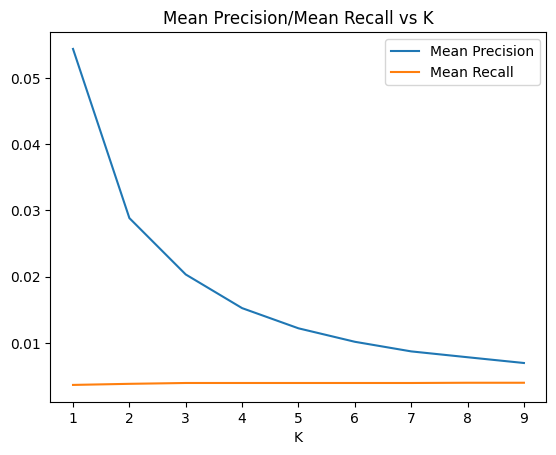

In [28]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def compute_metrics(association_rules_ls, train_data, test_data, k):
    user_association_ls = []
    recall_dict = {}
    precision_dict = {}
    for user_id, transaction in train_data.items():
        for antecedant in transaction:
            for association_rule in association_rules_ls:
                if antecedant == association_rule[0][0]:
                    user_association_ls.append(association_rule)
        
        #Sorting based on confidence
        user_association_ls = sorted(user_association_ls, key = lambda x: -x[2])
        user_recommendation_ls = [x[0][1:] for x in user_association_ls]
        user_recommendation_ls = flatten(user_recommendation_ls)[0:k]
        test_item_ls = test_data[user_id]
        hit_set = set(user_recommendation_ls).intersection(set(test_item_ls))
        recall = len(hit_set)/len(test_item_ls)
        precision = len(hit_set)/len(user_recommendation_ls)
        recall_dict[user_id] = recall
        precision_dict[user_id] = precision

    precision_ls, recall_ls = [*precision_dict.values()], [*recall_dict.values()]
    return sum(precision_ls)/len(precision_ls), sum(recall_ls)/len(recall_ls), precision_dict, recall_dict 

def plot_graphs(k_ls, mean_precision_ls, mean_recall_ls):
    plt.plot(k_ls, mean_precision_ls, label='Mean Precision')
    plt.plot(k_ls, mean_recall_ls, label='Mean Recall')
    plt.xlabel(f"K")
    plt.legend()
    plt.title(f"Mean Precision/Mean Recall vs K")
    plt.show()

mean_precision_ls = []
mean_recall_ls = []
k_ls = []
for k in range(1, 10):
    k_ls.append(k)
    mean_precision, mean_recall, _, _ = compute_metrics(association_rules_ls_conf, train_df_key_value, test_df_key_value, k)
    mean_precision_ls.append(mean_precision)
    mean_recall_ls.append(mean_recall)
plot_graphs(k_ls, mean_precision_ls, mean_recall_ls)
del mean_precision_ls, mean_recall_ls, k, mean_precision, mean_recall, k_ls

----

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-
- Take a sample example of users and their movie ratings from the test set and Display precision and recall graphs.

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

- The cell below computes the average precision and the average recall values for a few selected users while varying k from 1 to 10.

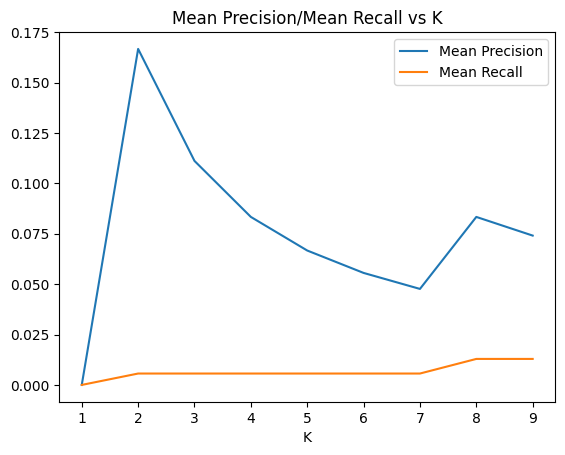

In [29]:
mean_precision_ls = []
mean_recall_ls = []
k_ls = []
num_users = 3
user_ids = [1,6,8]
for k in range(1,10):
    precision = 0.0
    recall = 0.0
    _, _, precision_dict, recall_dict = compute_metrics(association_rules_ls_conf, train_df_key_value, test_df_key_value, k)
    for user_id in user_ids:
        precision += precision_dict[user_id]
        recall += recall_dict[user_id]
    precision = precision / num_users
    recall = recall / num_users
    k_ls.append(k)
    mean_precision_ls.append(precision)
    mean_recall_ls.append(recall)
#Plot graphs
plot_graphs(k_ls, mean_precision_ls, mean_recall_ls)
del mean_precision_ls, mean_recall_ls, k_ls, num_users, user_ids
del k, precision, recall, precision_dict, recall_dict, user_id


----